In [39]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchsummary import summary
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
import os
import random
import matplotlib.pyplot as plt
from gen_disc_networks import Generator, Discriminator
from customDataSet import CustomDataset, get_data_loaders
from evaluate_rmse import evaluate_rmse

# Creating a cGAN model

## Definiting the parameters, Generaor and Discriminator networks

In [40]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Hyperparameters
pixel_size = 256
batch_size = 16
noise_dim = 1
lr = 0.0002 / 10
num_epochs = 50
ifTrain = False
ifSaveModel = True
ifCalcRMSE = True
ifSaveFig = True

torch.cuda.empty_cache()
generator = Generator(noise_dim).to(device)
discriminator = Discriminator().to(device)

if os.path.isfile('generator_trained.pth'):
    generator.load_state_dict(torch.load('generator_trained.pth'))
    print("The pre-trained generator loaded")
if os.path.isfile('discriminator_trained.pth'):
    discriminator.load_state_dict(torch.load('discriminator_trained.pth'))
    print("The pre-trained discriminator loaded")


The pre-trained generator loaded
The pre-trained discriminator loaded


## Getting the model summary

In [41]:
#G.get_submodule
print("Generator summary")
summary(generator, [(1, pixel_size, pixel_size), (noise_dim, pixel_size, pixel_size)])

print("Discriminator summary")
summary(discriminator, (2, 256, 256))
#for parameter in G.parameters():
#    print(parameter)
# Initialize models


Generator summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           2,048
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4          [-1, 128, 64, 64]         131,072
       BatchNorm2d-5          [-1, 128, 64, 64]             256
              ReLU-6          [-1, 128, 64, 64]               0
            Conv2d-7          [-1, 256, 32, 32]         524,288
       BatchNorm2d-8          [-1, 256, 32, 32]             512
              ReLU-9          [-1, 256, 32, 32]               0
           Conv2d-10          [-1, 512, 16, 16]       2,097,152
      BatchNorm2d-11          [-1, 512, 16, 16]           1,024
             ReLU-12          [-1, 512, 16, 16]               0
           Conv2d-13           [-1, 1024, 8, 8]       8,388,608
      BatchNorm2d-14 

## Splitting the dataset to train and test set

In [42]:
# Create dataset instance

dataset_dpm_path = 'dataset/DPM/'
dataset_irt_path = 'dataset/IRT2/'


# Create data loader
#data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
train_loader, test_loader = get_data_loaders(dataset_dpm_path, dataset_irt_path, batch_size, test_split=0.8)


#plt.imshow(image_dpm_np, cmap='gray')
#plt.axis('off')
#plt.show()
#print(len(test_loader.dataset))
print(len(train_loader.dataset))


11216


## Training the model

In [49]:
if ifTrain == True:
    
    # Define loss function and optimizers
    criterion = nn.BCELoss()
    d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    # Training loop
    for epoch in range(num_epochs):
        progress_bar = tqdm(train_loader, desc=f'Epoch [{epoch+1}/{num_epochs}]', leave=False)
        for i, batch in enumerate(progress_bar):
            # Unpack the batch
            simulated_map, measured_map = batch
    
            # Move tensors to device
            simulated_map = simulated_map.to(device)
            measured_map = measured_map.to(device)

    
            ############################
            # Train discriminator
            ############################
            d_optimizer.zero_grad()
    
    
    
            # Train with real data
            real_labels = torch.ones(batch_size, 1, device=device)
            # Concatenate the simulated map and measured map along the channel dimension
            real_inputs = torch.cat((simulated_map, measured_map), dim=1)
#            print(f"real input: {real_inputs.size()}")
            real_outputs = discriminator(real_inputs)
    #        print(f"real label: {real_labels.size()}")
    #        print(f"real output: {real_outputs.size()}")
            d_loss_real = criterion(real_outputs.squeeze(), real_labels.squeeze())
            d_loss_real.backward()
    
            # Train with fake data
            noise_map = torch.randn(batch_size, noise_dim, pixel_size, pixel_size, device=device)
            fake_images = generator(simulated_map, noise_map)
            fake_labels = torch.zeros(batch_size, 1, device=device)
    #        print(f"fake image size @generator's output: {fake_images.size()}")
    #        print(f"simulated_map size: {simulated_map.size()}")
            fake_inputs = torch.cat((simulated_map, fake_images), dim=1)
            fake_outputs = discriminator(fake_inputs)
    #        print(f"fake label: {fake_labels.size()}")
    #        print(f"fake output: {fake_outputs.size()}")
            d_loss_fake = criterion(fake_outputs.squeeze(), fake_labels.squeeze())
            d_loss_fake.backward()
    
            d_loss = d_loss_real + d_loss_fake
            d_optimizer.step()
    
            ############################
            # Train generator
            ############################
            g_optimizer.zero_grad()
    
            # Generate fake images
            noise_map = torch.randn(batch_size, noise_dim, pixel_size, pixel_size, device=device)
            fake_images = generator(simulated_map, noise_map)
    
            # Train generator with discriminator feedback
            fake_inputs = torch.cat((simulated_map, fake_images), dim=1)
            outputs = discriminator(fake_inputs)
            g_loss = criterion(outputs.squeeze(), real_labels.squeeze())
            g_loss.backward()
            g_optimizer.step()
    
    
    
            ############################
            # Print losses
            ############################
#            if i % 10 == 0:
#                print(f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(train_loader)}], "
#                      f"D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")
        print(f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(train_loader)}], "
                      f"D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")
        if ifSaveModel == True:
            torch.save(discriminator.state_dict(), 'discriminator_trained.pth')
            torch.save(discriminator, 'discriminator_entire_model.pth')
            torch.save(generator.state_dict(), 'generator_trained.pth')
            torch.save(generator, 'generator_entire_model.pth')
            print(f"Model saved at epoch {epoch}")


# Evaluating the results

## Showing a sample synthetic map

Random index: 6250


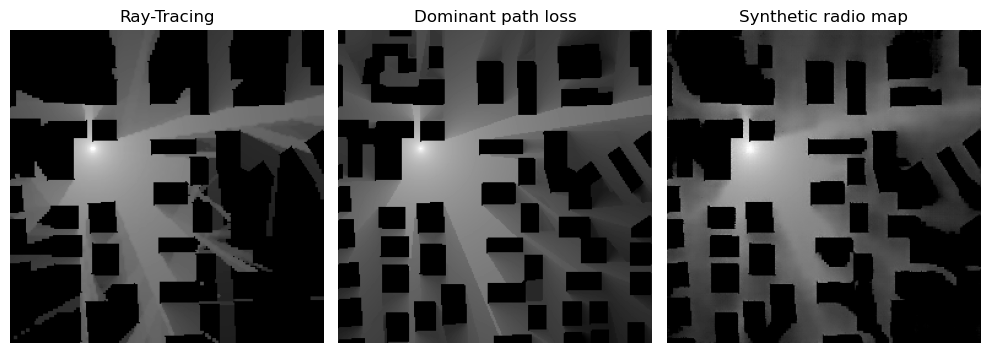

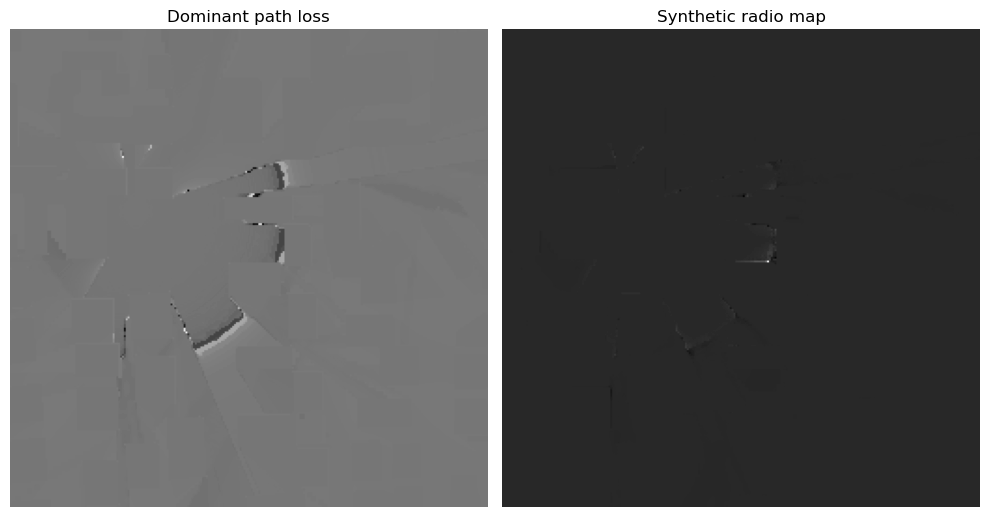

In [62]:
# Generate a new image
#from synthetic_map import generate_image
def generate_image(generator, simulated_map, noise_dim):
    # Prepare simulated map and noise map
    simulated_map = simulated_map.to(device)
    noise_map = torch.randn(1, noise_dim, pixel_size, pixel_size, device=device)

    # Generate image
    with torch.no_grad():
        generated_image = generator(simulated_map, noise_map)
   # Denormalize the generated image from [-1, 1] to [0, 1]
#    generated_image = (generated_image + 1) / 2 
    return generated_image

# Choose a random index
# Choose a random index#
random_index = 10372
random_index = random.randint(0, len(test_loader.dataset) - 1)
print(f"Random index: {random_index}")

# Get the image at the random index
image_dpm, image_irt = test_loader.dataset[random_index]

# Convert tensor to numpy array and remove batch dimension
image_dpm_np = image_dpm.squeeze().numpy()
image_irt_np = image_irt.squeeze().numpy()

simulated_map = torch.from_numpy(image_dpm_np).reshape(1, 1 , pixel_size, pixel_size)
synthetic_image = generate_image(generator, simulated_map, noise_dim).to("cpu")
synthetic_image = synthetic_image.squeeze().numpy()

# Plot the image
# Create a figure with 1 row and 3 columns
# Plot each image in a subplot
fig = plt.figure(figsize=(10, 7)) 
fig.add_subplot(1, 3, 1) 
plt.imshow(image_irt_np , cmap='gray')
plt.axis('off')  # Hide axes for a cleaner look
plt.title('Ray-Tracing')

fig.add_subplot(1, 3, 2) 
plt.imshow(image_dpm_np , cmap='gray')
plt.axis('off')  # Hide axes for a cleaner look
plt.title('Dominant path loss')

fig.add_subplot(1, 3, 3)
plt.imshow(synthetic_image, cmap='gray')
plt.axis('off')  # Hide axes for a cleaner look
plt.title('Synthetic radio map')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()
# Save the full figure...
if ifSaveFig:
    fig.savefig("/home/ehsan/git/juelich-presentation/pics/all_methods_comparison.png")


#img = Image.fromarray(np.uint8(255 * image_irt_np))  # no opencv required
#if ifSaveFig:
#    img.save("/home/ehsan/git/juelich-presentation/pics/irt.png")
    
#img = Image.fromarray(np.uint8(255 * image_dpm_np))  # no opencv required
#if ifSaveFig:
#    img.save("/home/ehsan/git/juelich-presentation/pics/dpm.png")
    
#img = Image.fromarray(np.uint8(255 * synthetic_image))  # no opencv required
#if ifSaveFig:
#    img.save("/home/ehsan/git/juelich-presentation/pics/synthetic.png")


### Plot the error images
fig = plt.figure(figsize=(10, 7)) 
fig.add_subplot(1, 2, 1) 
error_dpm = 100*(image_irt_np -image_dpm_np) / image_irt_np
plt.imshow(error_dpm , cmap='gray')
plt.axis('off')  # Hide axes for a cleaner look
plt.title('Dominant path loss')

fig.add_subplot(1, 2, 2) 
error_synthetic = 100*(image_irt_np - synthetic_image) / image_irt_np
plt.imshow(error_synthetic , cmap='gray')
plt.axis('off')  # Hide axes for a cleaner look
plt.title('Synthetic radio map')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()
# Save the full figure...
if ifSaveFig:
    fig.savefig("/home/ehsan/git/juelich-presentation/pics/error_image_comparison.png")

random_index

## Calculate the RMSE on the test set

In [46]:
if ifCalcRMSE:
    avg_rmse_generated, avg_rmse_simulated = evaluate_rmse(generator, test_loader, noise_dim)
    print(f"Average RMSE for generated images: {avg_rmse_generated}")
    print(f"Average RMSE for simulated maps: {avg_rmse_simulated}")
    improvement = (1 - avg_rmse_generated / avg_rmse_simulated)*100
    print(f"Improvement in RMSE: {improvement}")


  0%|▏                                                                | 10/2804 [00:00<04:28, 10.40it/s]

Average RMSE for generated images: 0.08694474096409976
Average RMSE for simulated maps: 0.09129639809146863
Improvement in RMSE: 4.766515676783866


## Visualizing the generator

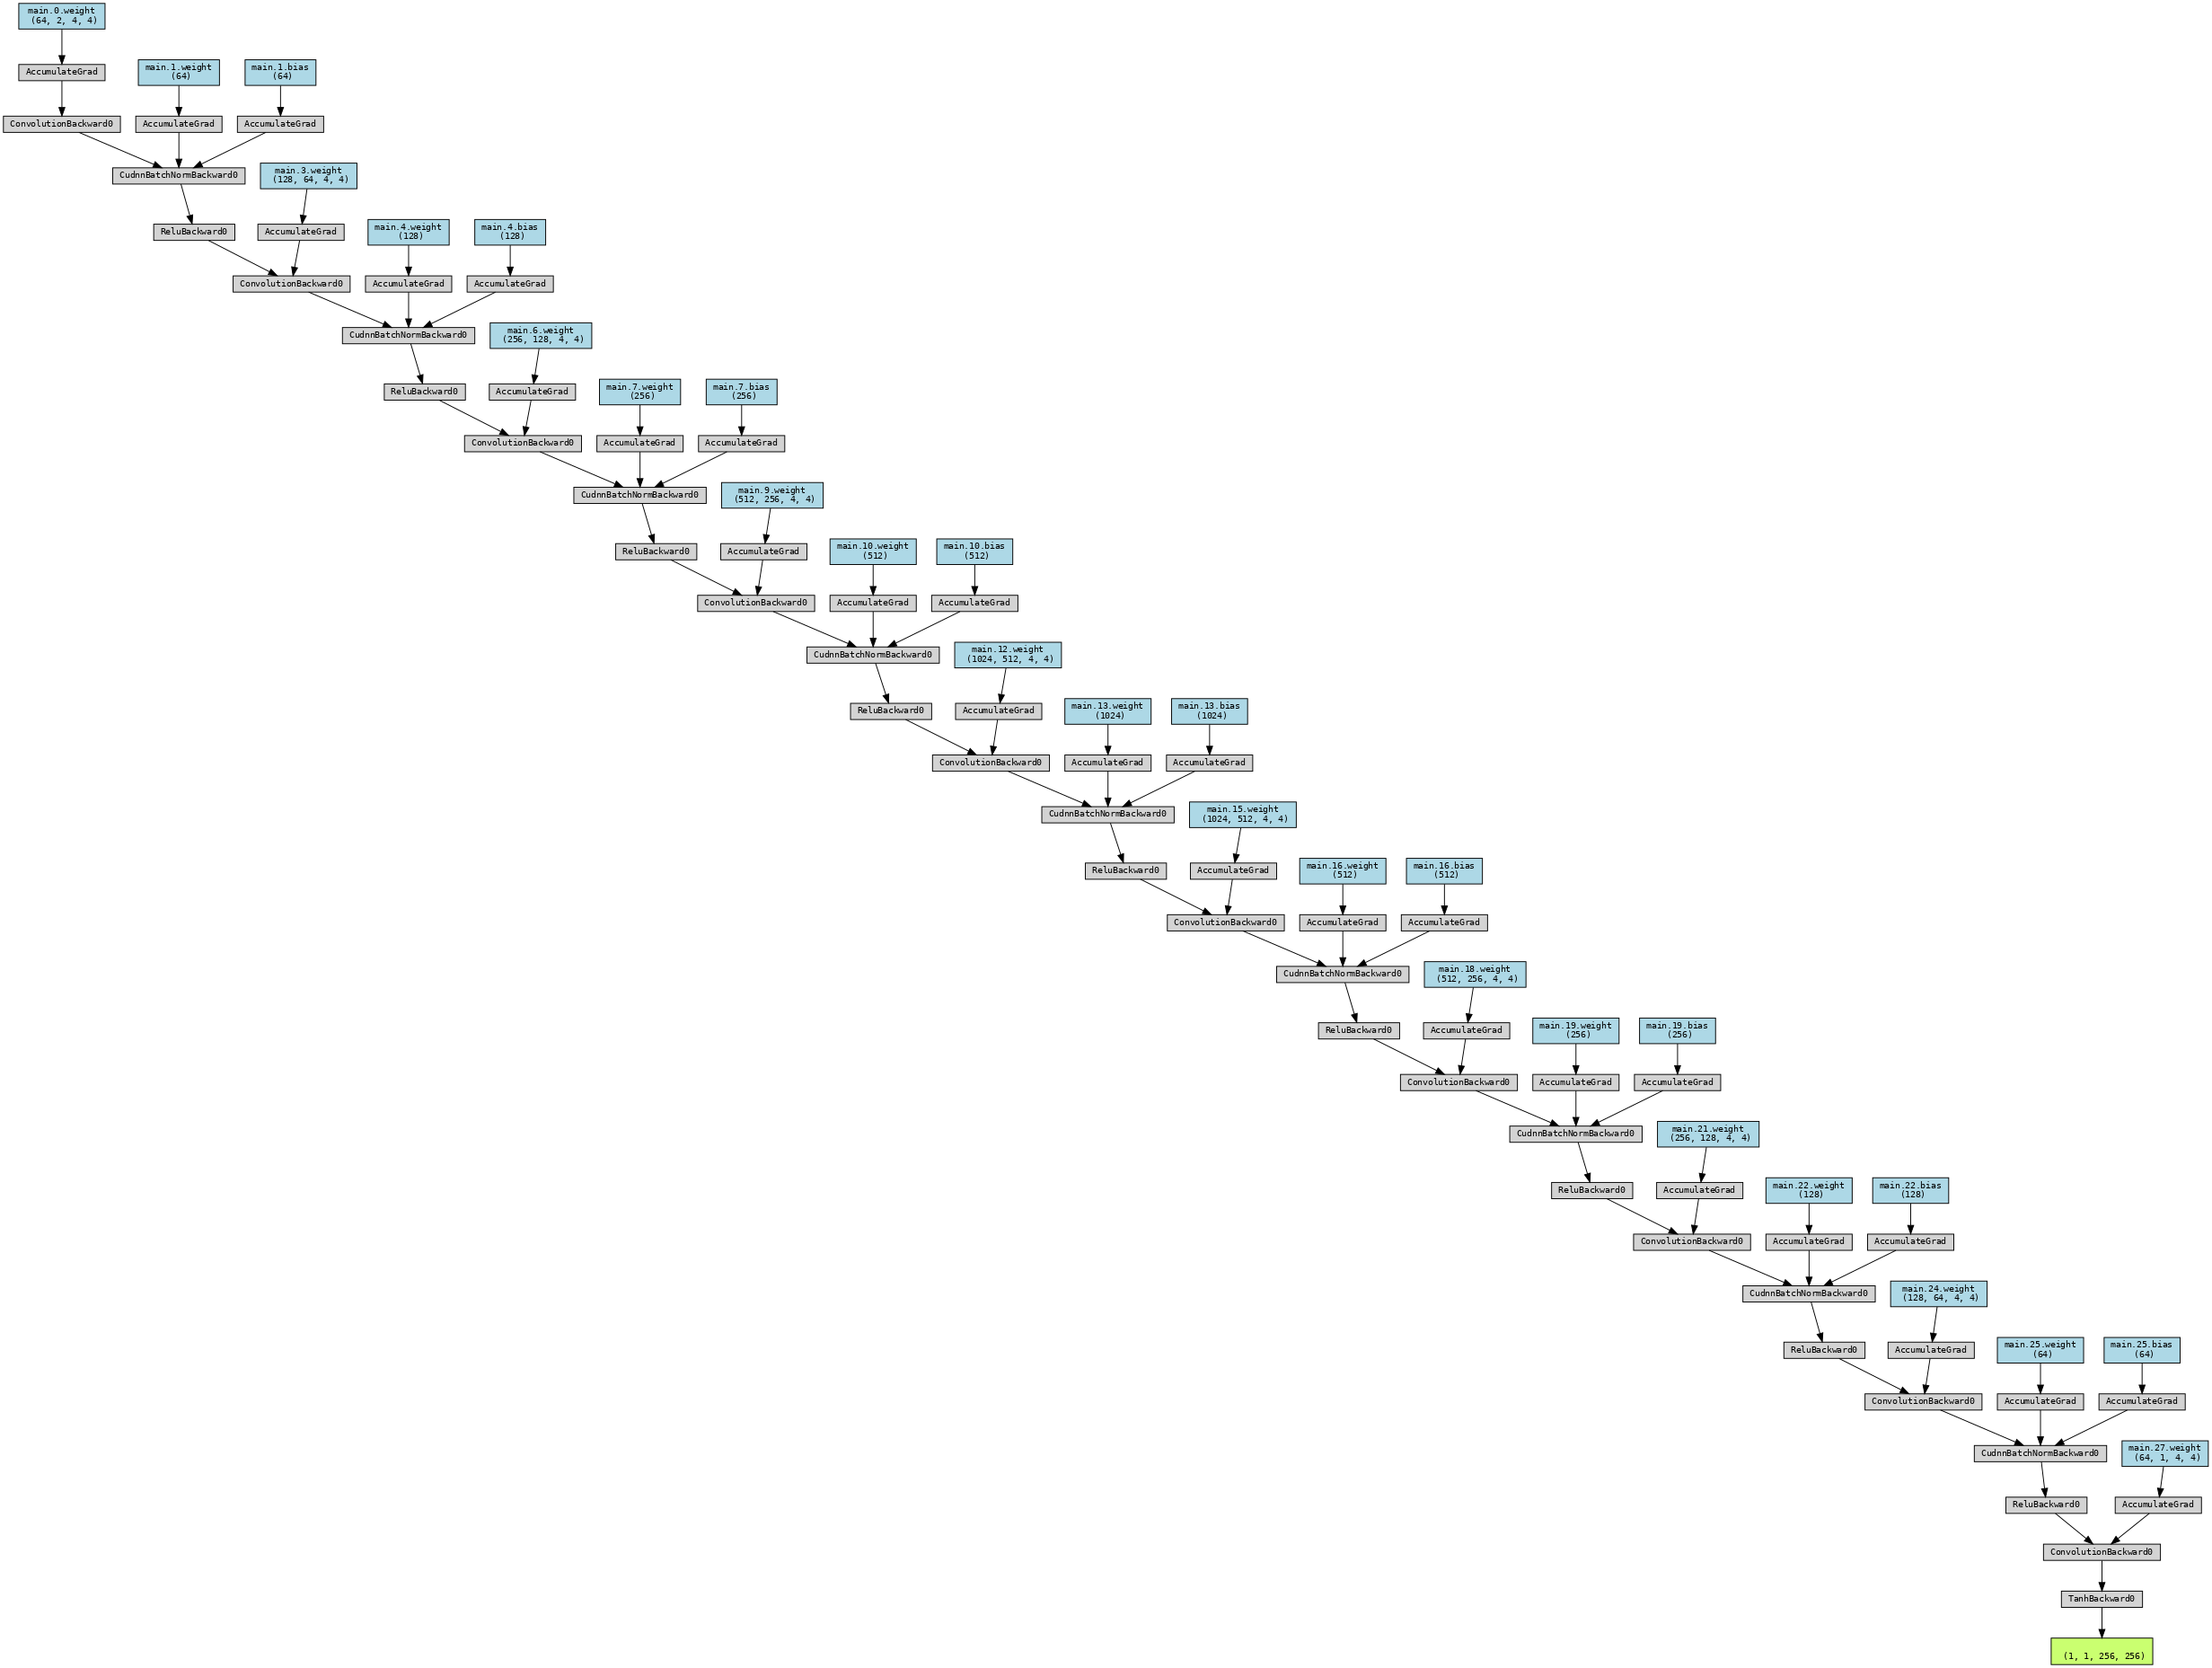

In [68]:
import torch
from torchviz import make_dot
import torch.onnx


# Create a dummy input for the generator (batch size 1)
dummy_input = torch.randn(1, 1, 256, 256).to(device)
# Generate the visualization
noise_map = torch.randn(1, noise_dim, pixel_size, pixel_size, device=device).to(device)
output = generator(dummy_input, noise_map)
model_viz = make_dot(output, params=dict(generator.named_parameters()))
# Render the graph to a file
model_viz.render("generator_architecture", format="png")

# Display the graph inline (optional, for Jupyter/Colab)
from IPython.display import Image
Image(filename="generator_architecture.png")



## Visualizing the discriminator

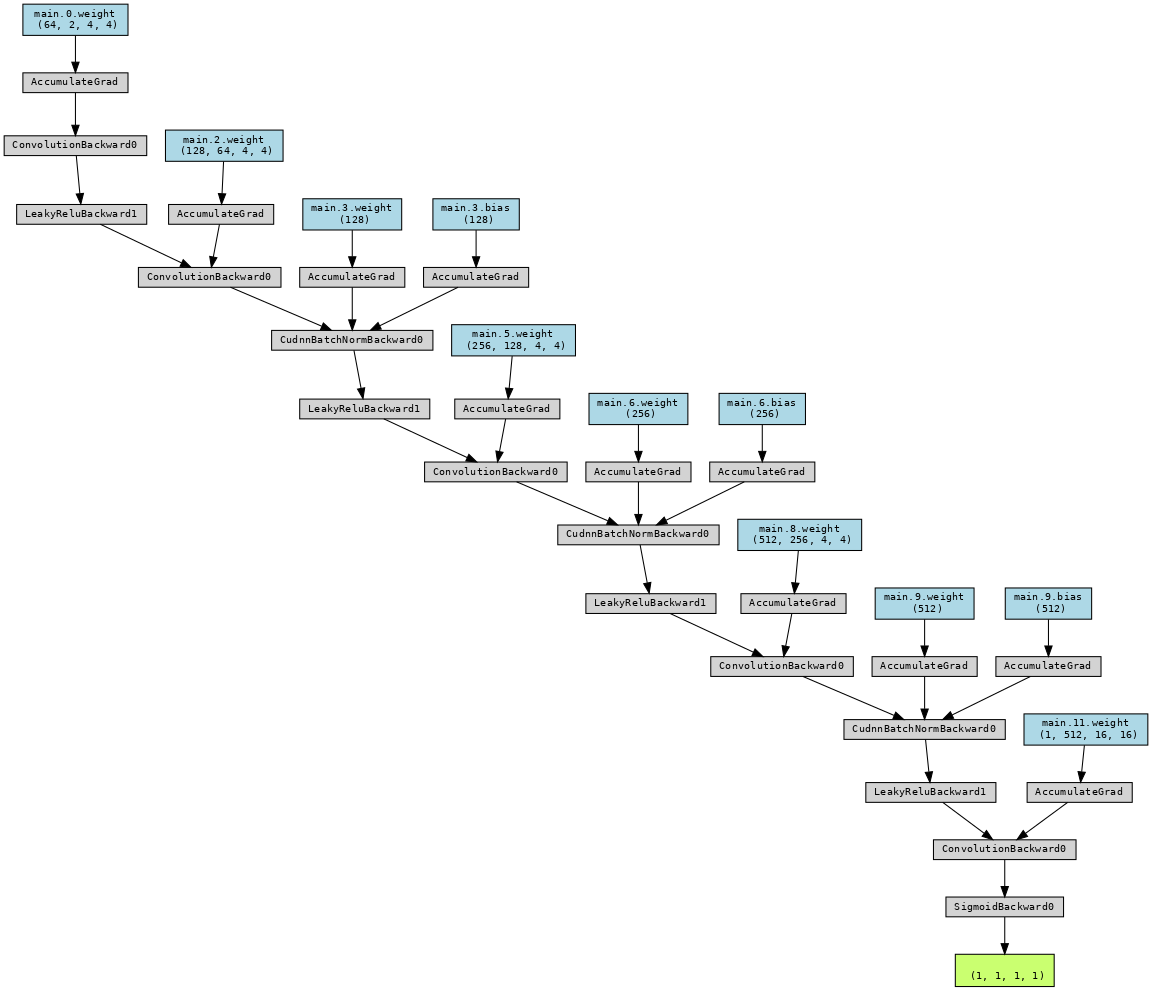

In [64]:
# Create a dummy input for the discriminator (batch size 1, single-channel grayscale image)
dummy_input = torch.randn(1, 2, 256, 256).to(device)

# Generate the visualization
#real_inputs = torch.cat((simulated_map, measured_map), dim=1)
output = discriminator(dummy_input)
model_viz = make_dot(output, params=dict(discriminator.named_parameters()))

# Render the graph to a file
model_viz.render("discriminator_architecture", format="png")

# Display the graph inline (optional, for Jupyter/Colab)
Image(filename="discriminator_architecture.png")
